In [1]:
# Author: Jack Haek
# Dataset Used: MNIST
# CPU implementation of training a Feed-Forward Neural Network
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np

#Specific for the torch MNIST Dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Variables that we can tune
DATA_ROOT = "data"
BATCH_SIZE = 16
LEARN_RATE = 0.001
EPOCHS = 3

In [3]:
# Grab Data from PyTorch - Raw Download
training_data = datasets.MNIST(root=DATA_ROOT, train = True, download = True, transform=ToTensor())
testing_data = datasets.MNIST(root=DATA_ROOT, train = False, download = True, transform=ToTensor())

# Import the data so we can actually use it
train_set = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle = True)
test_set = torch.utils.data.DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle = True)

In [4]:
# Ensure that we can access the data and see how it is organized
for data in train_set:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

The image is a 0


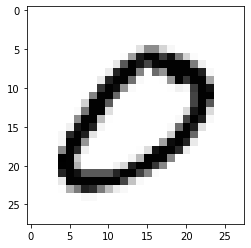

In [5]:
# Look at any image in the first batch.
# Note that IMAGE_NUMBER is zero indexed
IMAGE_NUMBER = 0
if IMAGE_NUMBER >= 0 and IMAGE_NUMBER < BATCH_SIZE and isinstance(IMAGE_NUMBER, int):
    x, y = data[0][IMAGE_NUMBER], data[1][IMAGE_NUMBER]
    plt.imshow(x.view(28, 28), cmap = "Greys")
    print("The image is a " + str(int(y)))

100%|██████████| 7500/7500 [00:06<00:00, 1191.68it/s]


[9.871666666666666, 11.236666666666666, 9.93, 10.218333333333334, 9.736666666666666, 9.035, 9.863333333333333, 10.441666666666666, 9.751666666666667, 9.915000000000001]


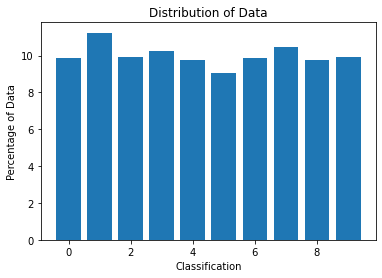

In [6]:
# Check the balance of the data
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
percentages = []
x_axis = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for data in tqdm(train_set):
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total +=1
        
for i in counter_dict:
    percentages.append(counter_dict[i]/total*100)

print(percentages)
plt.bar(x_axis, percentages)
plt.title("Distribution of Data")
plt.xlabel("Classification")
plt.ylabel("Percentage of Data")
plt.show()

In [7]:
# Build the network
class Net(nn.Module):
    def __init__(self):
        # Initialize the nn.Module class
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64) # Images are 28 by 28 so that is the input for the first layer
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10) # 10 is the output because we have 10 separate classes
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)

In [8]:
# Test the model and check to make sure the output is valid
net = Net()
X = torch.rand((28, 28))
output = net(X.view(-1, 28*28))
print(output)

tensor([[-2.3251, -2.2091, -2.4218, -2.3637, -2.2604, -2.3378, -2.2197, -2.3619,
         -2.2372, -2.3116]], grad_fn=<LogSoftmaxBackward0>)


In [9]:
# Define the optimizer algorithm. PyTorch comes with a few. They are generally good
# Note that the time.sleep functions are used so that tqdm displays correctly
optimizer = optim.Adam(net.parameters(), lr=LEARN_RATE)
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    for data in tqdm(train_set):
        # data is the whole batch
        X, y = data
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    time.sleep(0.5)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(train_set):
            X, y = data
            output = net(X.view(-1, 28*28))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    train_losses.append(float(loss))
    train_accuracies.append(float(correct/total))
    time.sleep(0.5)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(test_set):
            X, y = data
            output = net(X.view(-1, 28*28))
            loss = F.nll_loss(output, y)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    test_losses.append(float(loss))
    accuracy = correct/total
    test_accuracies.append(accuracy)
    print(f"Train Loss: {round(train_losses[-1], 3)}")
    print(f"Test Loss: {round(test_losses[-1], 3)}")
    print(f"Train Accuracy: {round(train_accuracies[-1]*100, 3)}")
    print(f"Test Accuracy: {round(test_accuracies[-1]*100, 3)}")
    time.sleep(0.5)

100%|██████████| 1250/1250 [00:01<00:00, 781.49it/s]


Train Loss: 0.241
Test Loss: 0.043
Train Accuracy: 96.182
Train Accuracy: 96.182


100%|██████████| 1250/1250 [00:01<00:00, 793.48it/s]


Train Loss: 0.111
Test Loss: 0.02
Train Accuracy: 96.9
Train Accuracy: 96.9


100%|██████████| 1250/1250 [00:01<00:00, 793.48it/s]


Train Loss: 0.001
Test Loss: 0.004
Train Accuracy: 97.585
Train Accuracy: 97.585


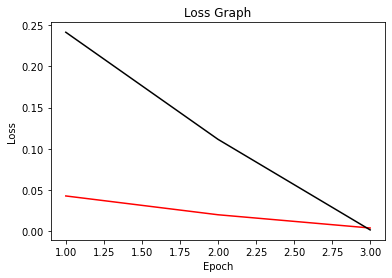

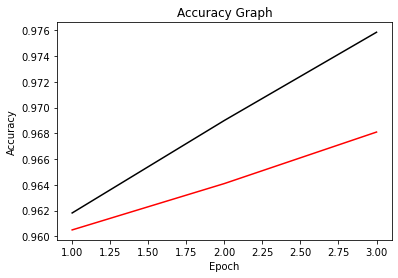

In [10]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, dtype=int)
plt.plot(x_axis, test_losses, color='Red', label = 'Test Loss')
plt.plot(x_axis, train_losses, color='Black', label = 'Train Loss')
plt.title("Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(x_axis, test_accuracies, color='Red', label = 'Test Loss')
plt.plot(x_axis, train_accuracies, color='Black', label = 'Train Loss')
plt.title("Accuracy Graph")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()